In [1]:
# necessary imports
import numpy as np

from squlearn.util import Executor
from squlearn.encoding_circuits import ChebPQC
from squlearn.kernel.matrix import FidelityKernel
from squlearn.kernel.ml import QGPR
from squlearn.kernel.optimization import KernelOptimizer
from squlearn.kernel.optimization import NLL

In [2]:
# Generate training data.
def func(x):
    return np.sin(3 * x) * x * x


noise_std = 0.1
X_test = np.linspace(-1, 1, 100)
Y_test = func(X_test)
X_train = np.linspace(-1, 1, 15)
Y_train = func(X_train) + np.random.normal(scale=noise_std, size=len(X_train))

In [3]:
# set up quantum kernel and qgpr
num_qubits = 4
enc_circuit = ChebPQC(num_qubits, num_features=1, num_layers=2)
q_kernel = FidelityKernel(
    encoding_circuit=enc_circuit, executor=Executor("statevector_simulator"), parameter_seed=0
)

array([ 0.30670429,  1.35207467,  0.64568133,  0.28200936,  0.01      ,
        1.34      ,  2.67      ,  4.        ,  5.82655809, -1.46471707,
        3.66592495,  0.36310427,  0.01      ,  1.34      ,  2.67      ,
        4.        , -6.02911343,  4.17982425,  3.49542082,  4.64970979,
        3.00724774,  1.8796687 , -0.24203231,  1.7626168 ])

In [4]:
from squlearn.optimizers import Adam

adam = Adam(options={"maxiter": 20, "lr": 0.1})
nll_loss = NLL(quantum_kernel=q_kernel, sigma=noise_std**2)
optimizer = KernelOptimizer(loss=nll_loss, optimizer=adam)

In [5]:
opt_result = optimizer.run_optimization(x=X_train.reshape(-1, 1), y=Y_train)

In [6]:
# perform qgpr
optimal_parameters = opt_result.x
q_kernel.assign_parameters(optimal_parameters)
qgpr_ansatz = QGPR(quantum_kernel=q_kernel, sigma=noise_std**2)
qgpr_ansatz.fit(X_train=X_train.reshape(-1, 1), y_train=Y_train)
qgpr_mean, qgpr_std = qgpr_ansatz.predict(X_test=X_test.reshape(-1, 1))

Regularizing full Gram matrix
Reconstruction error 1.9230431483330257e-11


Text(0, 0.5, '$f(x)$')

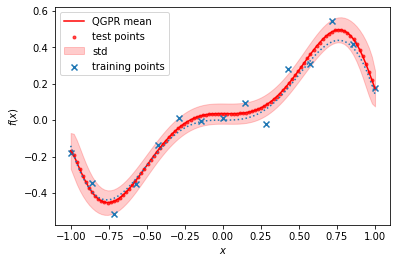

In [7]:
from matplotlib import pyplot as plt

# plot result
plt.plot(X_test.reshape(-1, 1), qgpr_mean, color="red", label="QGPR mean")
plt.scatter(
    X_test.reshape(-1, 1), qgpr_mean, marker=".", label="test points", color="red", alpha=0.7
)
plt.fill_between(
    X_test.reshape(-1),
    qgpr_mean.reshape(-1) - qgpr_std,
    qgpr_mean.reshape(-1) + qgpr_std,
    color="red",
    label="std",
    alpha=0.2,
)
plt.scatter(X_train, Y_train, marker="x", label="training points")
plt.plot(X_test, Y_test, linestyle="dotted")
plt.legend()
plt.xlabel("$x$")
plt.ylabel("$f(x)$")